# News EDA and model building

In [1]:
%pip install pandas matplotlib nltk scikit-learn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Load and first look on data

In [3]:
data = pd.read_csv("financedata.csv", sep=",", header=None, encoding="utf-8", encoding_errors="ignore")
data.head()

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [4]:
data.columns = ["Sentiment", "News_text"]
data.head()

,Sentiment,News_text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   News_text  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [6]:
data["Sentiment"].value_counts(normalize=True)

Sentiment
neutral     0.594098
positive    0.281263
negative    0.124639
Name: proportion, dtype: float64

<Axes: title={'center': 'Distribution of Sentiment column in the dataset'}, xlabel='Sentiment'>

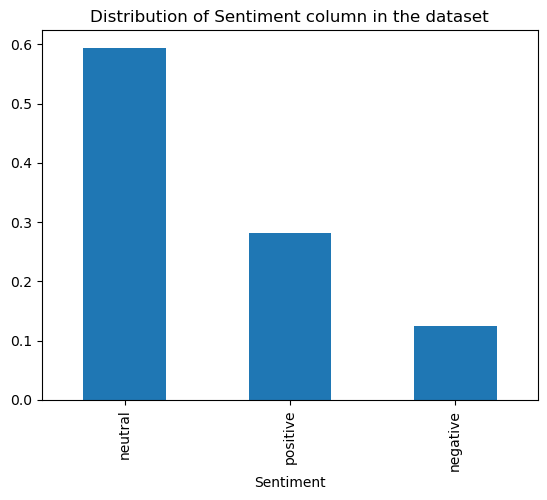

In [7]:
data["Sentiment"].value_counts(normalize=True).plot(kind="bar", title="Distribution of Sentiment column in the dataset")

## Preprocess data

In [8]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
data["original_label"] = data["Sentiment"]
data["Sentiment"] = le.fit_transform(data["Sentiment"]) # Label encoder transformation => [neutral = 1, negative = 0, positive = 2]
data.head()

,Sentiment,News_text,original_label
0,1,"According to Gran , the company has no plans t...",neutral
1,1,Technopolis plans to develop in stages an area...,neutral
2,0,The international electronic industry company ...,negative
3,2,With the new production plant the company woul...,positive
4,2,According to the company 's updated strategy f...,positive


In [9]:
import re
import nltk
import string


def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

<>:10: SyntaxWarning: invalid escape sequence '\['
<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:10: SyntaxWarning: invalid escape sequence '\['
<>:11: SyntaxWarning: invalid escape sequence '\S'
<>:15: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_25087/3540884652.py:10: SyntaxWarning: invalid escape sequence '\['
  text = re.sub('\[.*?\]', '', text)
/tmp/ipykernel_25087/3540884652.py:11: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('https?://\S+|www\.\S+', '', text)
/tmp/ipykernel_25087/3540884652.py:15: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('\w*\d\w*', '', text)


In [10]:
data["preprocessed_text"] = data["News_text"].apply(str).apply(lambda x: text_preprocessing(x))

In [11]:
data.head()

,Sentiment,News_text,original_label,preprocessed_text
0,1,"According to Gran , the company has no plans t...",neutral,according to gran the company has no plans to ...
1,1,Technopolis plans to develop in stages an area...,neutral,technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...,negative,the international electronic industry company ...
3,2,With the new production plant the company woul...,positive,with the new production plant the company woul...
4,2,According to the company 's updated strategy f...,positive,according to the company s updated strategy fo...


## Data splitting

In [12]:
X = data[["preprocessed_text"]]
y = data["Sentiment"]

X, y

(                                      preprocessed_text
 0     according to gran the company has no plans to ...
 1     technopolis plans to develop in stages an area...
 2     the international electronic industry company ...
 3     with the new production plant the company woul...
 4     according to the company s updated strategy fo...
 ...                                                 ...
 4841  london marketwatch share prices ended lower in...
 4842  rinkuskiai s beer sales fell by per cent to mi...
 4843  operating profit fell to eur mn from eur mn in...
 4844  net sales of the paper segment decreased to eu...
 4845  sales in finland decreased by in january while...
 
 [4846 rows x 1 columns],
 0       1
 1       1
 2       0
 3       2
 4       2
        ..
 4841    0
 4842    1
 4843    0
 4844    0
 4845    0
 Name: Sentiment, Length: 4846, dtype: int64)

In [13]:
from sklearn.model_selection import train_test_split

X_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape and size: {X_train.shape}, {X_train.size}")
print(f"Test shape and size: {x_test.shape}, {x_test.size}")

Train shape and size: (3876, 1), 3876
Test shape and size: (970, 1), 970


## Building baseline (logreg with tf-idf)

In [14]:
# Vectorize text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold

text_transformer = TfidfVectorizer(stop_words="english", lowercase=True, max_features=150000, ngram_range=(1, 2))
X_train_text = text_transformer.fit_transform(X_train["preprocessed_text"])
x_test_text = text_transformer.transform(x_test["preprocessed_text"])

In [15]:
X_train_text.shape, x_test_text.shape

((3876, 37449), (970, 37449))

In [16]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(C=5e1, solver="lbfgs", multi_class="multinomial", random_state=42, n_jobs=4)


In [17]:
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
cross_val = cross_val_score(log_reg_model, X_train_text, y_train, cv=stratified_k_fold, scoring="f1_micro")
cross_val

/home/alexa/miniconda3/envs/playground/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alexa/miniconda3/envs/playground/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

array([0.7564433 , 0.74709677, 0.75096774, 0.74064516, 0.72129032])

In [19]:
log_reg_model.fit(X_train_text, y_train)

/home/alexa/miniconda3/envs/playground/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=50.0, multi_class='multinomial', n_jobs=4, random_state=42)

In [20]:
preds = log_reg_model.predict(x_test_text)
preds

array([1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 0, 1, 1, 0, 2, 1, 1, 1,
       2, 1, 1, 2, 2, 1, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 2,
       1, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2,
       2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 1, 0, 2, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1,
       1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 0, 0, 1, 1, 1, 2, 1, 2,

In [21]:
print(x_test_text)

  (0, 36123)	0.41157500535246205
  (0, 33159)	0.46085028123151683
  (0, 28910)	0.2728189406197197
  (0, 27670)	0.46085028123151683
  (0, 27662)	0.3318989047895154
  (0, 18946)	0.30250747805734307
  (0, 8017)	0.3272197025924017
  (0, 5534)	0.15056389387952548
  (1, 33840)	0.3704389448210603
  (1, 32016)	0.4030381924810286
  (1, 32012)	0.35136960738825695
  (1, 29969)	0.34411978176741004
  (1, 9869)	0.2971581990886561
  (1, 8183)	0.4030381924810286
  (1, 6339)	0.35136960738825695
  (1, 1524)	0.2902633243823463
  (2, 34537)	0.4874344489194567
  (2, 26730)	0.2300896112653463
  (2, 25989)	0.2613665237144789
  (2, 25984)	0.17643412897451224
  (2, 23707)	0.19408342822926278
  (2, 20473)	0.13974957942855334
  (2, 19260)	0.29577453319549946
  (2, 18038)	0.30657740081394
  (2, 18037)	0.30657740081394
  :	:
  (967, 7026)	0.19281053389461691
  (967, 6418)	0.334288532408216
  (967, 3800)	0.24747299846376083
  (967, 1085)	0.334288532408216
  (968, 30616)	0.2906332801486615
  (968, 30596)	0.193572980

In [22]:
df_preds = pd.DataFrame(preds, columns=["sentiment"])
df_test = x_test
df_test["predictions"] = preds
df_test.reset_index()


,index,preprocessed_text,predictions
0,3207,the company was supposed to deliver machinery ...,1
1,1684,unc charlotte would also deploy ssh tectia con...,1
2,1044,in lee man had a combined annual production ca...,2
3,4145,that s a very high figure on the european scal...,1
4,1538,in finland the corresponding service is alma m...,1
...,...,...,...
965,3691,news corp s myspacecom web site will display s...,1
966,1507,both mr walden and mr ignatius will be respons...,1
967,1126,every partner will be allowed to buy a quantit...,1
968,180,diluted earnings per share eps rose to eur fro...,2


In [25]:
df_test.iloc[0], data.iloc[3207]["original_label"]

(preprocessed_text    the company was supposed to deliver machinery ...
 predictions                                                          1
 Name: 3207, dtype: object,
 'neutral')